In [1]:
import torch
from torch.nn import functional as F
from tqdm import tqdm
import numpy as np
import time
from matplotlib import pyplot as plt
from matplotlib import cm
import matplotlib as mpl
from model import get_model
from util import get_emd, emd_loss, grad_reverse, cos_sine
from data import MultinomialBatch

In [3]:
torch.manual_seed(0)
torch.set_default_dtype(torch.float32)

EPOCHS = 2000
PLOT = True
SAVE = True
PLOT_EVERY = 10
STEPS = EPOCHS // PLOT_EVERY

N = 8
Npoints = 6
EMBED_DIM = 2
scale = 4

# here we define the parametrization of 
def p_from_paramterization(parameters, q=True):
    t = torch.linspace(0, 1, 100).view(-1, 1)
    assert parameters.shape == (Npoints, 2)
    
    A, B, C, radii, centers, theta = parameters
    # A, B, C = parameters
    res = []
    res.append(t * B + (1 - t) * A)
    res.append(t * C + (1 - t) * B)
    res.append(t * A + (1 - t) * C)
    p = torch.vstack(res)
    p = p.view(-1, EMBED_DIM)

    theta = t * 2 * np.pi
    ellipse = torch.cat([torch.cos(theta), torch.sin(theta)], dim=1) * radii /4 + centers
    rot = theta[0] 
    ellipse = ellipse @ torch.tensor([[np.cos(rot), -np.sin(rot)], [np.sin(rot), np.cos(rot)]]).float()
    return torch.cat([p, ellipse], dim=0)

# Q
parameters = torch.rand(Npoints, EMBED_DIM) * scale
q = p_from_paramterization(parameters)
q = q.view(-1, EMBED_DIM) + torch.randn_like(q) * 0.05
E_q = torch.ones(q.shape[0], 1) / (q.shape[0])

# P
parameters = torch.rand(Npoints, EMBED_DIM) + scale / 2
parameters = parameters.requires_grad_()


p = p_from_paramterization(parameters).detach()
E_p = torch.ones(p.shape[0], 1) / p.shape[0]

def tensors_numpy():
    # E_p = E_p_.detach().softmax(dim=0)
    p = p_from_paramterization(parameters).detach()
    return map(lambda x: x.detach().numpy(), [p, q, E_p.view(-1), E_q.view(-1)])

  0%|          | 0/2000 [00:00<?, ?it/s]/var/folders/6s/r9c1s17x28d5yx5ggkn7dc3r0000gn/T/ipykernel_66927/1691594630.py:64: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  sc = ax.scatter(
emd_nn: +0.340| true: 0.689| Delta: -50.7%:   5%|▌         | 108/2000 [00:02<00:50, 37.74it/s]

3.6886842


emd_nn: +0.007| true: 0.060| Delta: -88.4%: : 2899it [00:57, 55.54it/s]                         

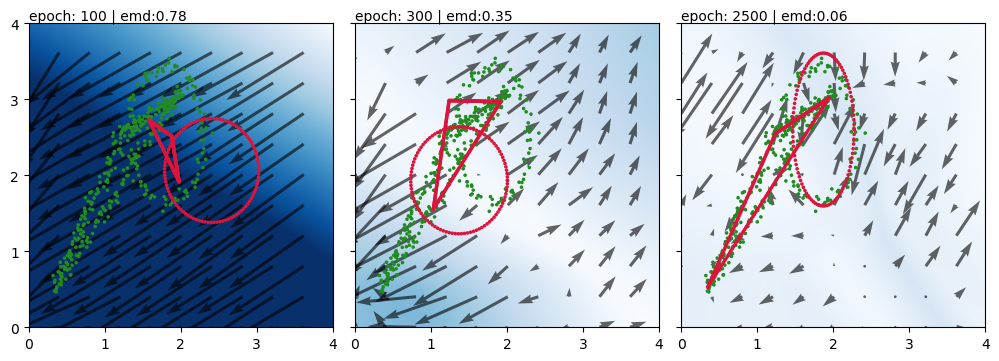

emd_nn: +0.007| true: 0.060| Delta: -88.4%: : 2900it [01:10, 55.54it/s]

In [4]:
DEBUG = False
from matplotlib.colors import LogNorm

torch.manual_seed(0)
model = get_model(
    use_norm=True,
    input_dim=EMBED_DIM,
    latent_dim=128,
    always_norm=False,
    ngroups=32 // 2,
    metric=1,
)
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-3, weight_decay=1e-2)
optimizer_p = torch.optim.SGD((parameters, ), lr=2.5e-1, momentum=0.1, dampening=0.6)


SCHEDULER = True
if SCHEDULER:
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, EPOCHS, eta_min=1e-5)


E_scale = 1000
p_numpy, q_numpy, E_p_numpy, E_q_numpy = tensors_numpy()
yscale = 2 / E_p_numpy.max()

fig, axes = plt.subplots(1, 3, figsize=(10, 3.5), sharey=True)
plt.tight_layout(pad=0.01, w_pad=0.01, h_pad=0.0)
xsteps = 200
ysteps = 250
linspacex = torch.linspace(0, 1, xsteps) * scale
linspacey = torch.linspace(0, 1, ysteps) * scale
domain = torch.cartesian_prod(linspacex, linspacey)
# vector field on domain
subdomain = domain.view(xsteps, ysteps, 2)[::xsteps//10, ::ysteps//10].reshape(-1, 2)
subdomain.requires_grad_()
n = subdomain.shape[0]
def init_ax(ax : plt.Axes):
    heatmap = ax.imshow(
        np.zeros((xsteps, ysteps)),
        extent=(0, scale, 0, scale),
        cmap="Blues_r",
        origin="lower",
        norm=LogNorm(vmin=0.01, vmax=1)
    )

    vfield = ax.quiver(
        *subdomain.detach().T,
        np.ones(n),
        np.ones(n),
        scale=.6,
        scale_units="xy",
        color="black",
        alpha=0.6,
        width=0.04,
        units="xy",
    )
    ax.set_xlim(0, scale)
    ax.set_ylim(0, scale)

    ax.set_yticks(np.arange(0, scale + 1))
    ax.scatter(q_numpy[:, 0], q_numpy[:, 1], s=E_q_numpy * E_scale, c="forestgreen")
    colors = np.arange(Npoints)[ ... , None] + np.zeros(p_numpy.shape[0]//Npoints)
    colors = colors.flatten() / (Npoints - 1)
    sc = ax.scatter(
        p_numpy[:, 0], p_numpy[:, 1], s=E_p_numpy * E_scale, c='crimson', cmap="tab10"
    )
    text = ax.text(0.0, 1.01, "", transform=ax.transAxes)
    return vfield, heatmap, sc, text


pbar = tqdm(total=EPOCHS, leave=True)


def train_step(p, q, Ep=None, Eq=None):
    fp = model(p)
    fq = model(q)
    return emd_loss(fp, fq, Ep, Eq)


batcher = MultinomialBatch(p, q, E_p, E_q)

epoch_count = 0
def plot_step(i, vfield, heatmap, sc, text):
    if DEBUG:
        i = 1
    epoch = epoch_count
    for _ in range(i):
        epoch +=  1
        optimizer.zero_grad()
        optimizer_p.zero_grad()
        # some stochastic steps
        # for _ in range(1):
        #     optimizer.zero_grad()
        #     optimizer_p.zero_grad()
        #     p_sample, q_sample = batcher(2)
        #     loss = train_step(p_sample, q_sample)
        #     loss.backward()
        #     optimizer.step()
        #     optimizer_p.zero_grad()
        # optimizer_p.step()
        p = p_from_paramterization(parameters)
        # E_p = E_p_.softmax(dim=0)
        loss = train_step(grad_reverse(p), q, grad_reverse(E_p), E_q)
        # fp = model(p)
        # fq = model(q)
        # loss = (fp * E_p).sum() - (fq * E_q).sum()
        emd_nn = -loss.item()
        # loss += hkr_lambda * F.hinge_embedding_loss(
        # torch.vstack([fp, fq]), - targets, margin=1)
        # loss = F.cross_entropy(torch.vstack([fp, fq]), targets)
        # loss = torch.log(1  + loss)
        # loss = torch.log(loss + 1)
        loss.backward()
        # p.grad = - p.grad * (1 + torch.rand_like(p) * 0.01)
        optimizer.step()
        optimizer_p.step()
        if SCHEDULER:
            scheduler.step()
        emd_true = get_emd(*tensors_numpy())
        emd_diff = (emd_nn - emd_true) / emd_true * 100
        msg = f"emd_nn: {emd_nn:+.3f}| "
        msg += f"true: {emd_true:.3f}| "
        msg += f"Delta: {emd_diff:.1f}%"
        pbar.set_description(msg)
        pbar.update()
    p_numpy, q_numpy, E_p_numpy, E_q_numpy = tensors_numpy()
    text.set_text(f"epoch: {epoch} | emd:{emd_true:.2f}")
    output = model(subdomain)
    grads = torch.autograd.grad(
        output, subdomain, grad_outputs=torch.ones_like(output)
    )[0]
    with torch.no_grad():
        output = model(domain).numpy().flatten()
    output = output - output.min()
    if i == 100:
        print(output.max())
    output/= 2
    vfield.set_UVC(*grads.T)

    c = cm.get_cmap("Blues")(output.reshape(xsteps, ysteps))
    heatmap.set_array(c)
    sc.set_offsets(p_numpy)

epochs = np.array([100, 300, 2500])
for ax, step in zip(axes, epochs):
    args = init_ax(ax)
    plot_step(step, *args)
fig.savefig("bothFit_test.pdf", dpi=300)